### Task: Build Simulation Orchestrator
* Create a rebase and non-rebasing token and simulate a series of N deposits
* https://docs.python.org/3/c-api/reflection.html

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor

from python.dev.agent import TokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.event import Mint

from python.dev.simulation.batch import WithdrawBatch
from python.dev.simulation.batch import DepositBatch
from python.dev.simulation.batch import SwapBatch

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel

In [2]:
apy = 0.123456
target1 = TokenAgent('T1_DEPOSIT')
target2 = TokenAgent('TCT_DEPOSIT')
user = UserAgent('sim_user')

In [3]:
mint_events1 = []
mint_events2 = []

for k in range(5):
    mint_event1 = Mint(10000, 0.1234567, True)
    mint_event2 = Mint(10000, 0.1234567, False)
    mint_events1.append(mint_event1)
    mint_events2.append(mint_event2)

In [4]:
n_events = 100

deposit_batches1 = []
deposit_batches2 = []

for k in range(5):
    dBatch1 = DepositBatch(target1, user, mint_events1[k])
    dBatch2 = DepositBatch(target2, user, mint_events2[k])
    
    deposit_batch1 = dBatch1.generate_events(apy, n_events)
    deposit_batch2 = dBatch2.generate_events(apy, n_events)
    
    deposit_batches1.append(deposit_batch1)
    deposit_batches2.append(deposit_batch2)

In [5]:
q = EventQueue(alternate_batches = True)

for k in range(5):
    q.add_event(MintAction(mint_events1[k], target1, user))
    q.add_event(MintAction(mint_events2[k], target2, user))
    q.add_event_batch(deposit_batches1[k])
    q.add_event_batch(deposit_batches2[k])

In [6]:
orchestrator = SimulationOrchestrator()
executor = EventExecutor(q, orchestrator)
executor.run()

### Plot output


In [7]:
T1 = target1.get_token()
TCT1 = target2.get_token()

t1_addrs = []
tct_addrs = []

for k in range(5):
    t1_addrs.append(target1.get_address(mint_events1[k].get_id()))
    tct_addrs.append(target2.get_address(mint_events2[k].get_id()))

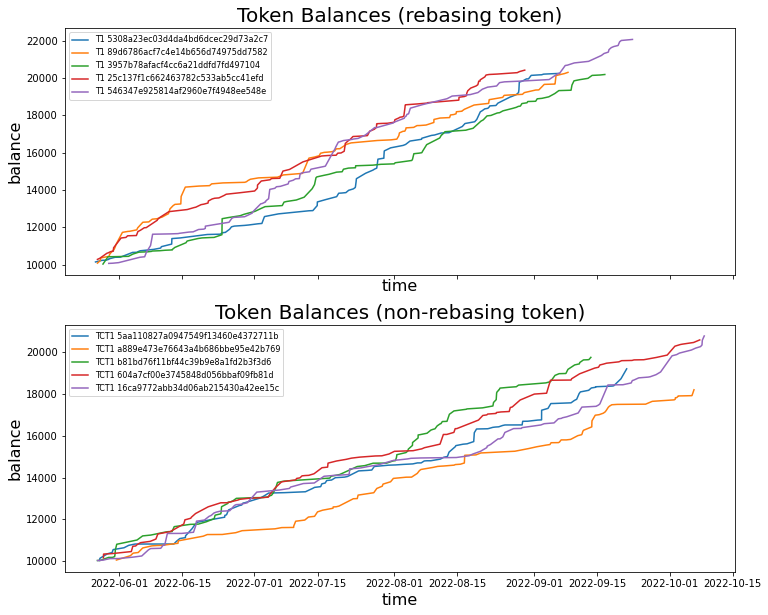

In [8]:
T_states = 5*[None]
final_balances = 5*[0]

fig, (T1_ax, TCT1_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

for m in range(5):
    T_states[m] = T1.get_state_series(t1_addrs[m])
    tSamp = T_states[m].get_tstamp() 
    balance = T_states[m].get_balance() 
    final_balances[m] = balance[-1]
    T1_ax.plot(tSamp, balance, label='T1 {}'.format(t1_addrs[m])) 

T1_ax.set_title("Token Balances (rebasing token)", fontsize=20)
T1_ax.set_ylabel("balance", fontsize=16)
T1_ax.set_xlabel('time', fontsize=16)
T1_ax.legend(fontsize=8)

for m in range(5):
    T_states[m] = TCT1.get_state_series(tct_addrs[m])
    tSamp = T_states[m].get_tstamp() 
    balance = T_states[m].get_balance() 
    final_balances[m] = balance[-1]
    TCT1_ax.plot(tSamp, balance, label='TCT1 {}'.format(tct_addrs[m])) 

TCT1_ax.set_title("Token Balances (non-rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("balance", fontsize=16)
TCT1_ax.set_xlabel('time', fontsize=16)
TCT1_ax.legend(fontsize=8)
        

### Reproduce Task 105:
* Add graph of token balances for each holder

In [9]:
n_events = 100
token_deltas = TokenDeltaModel(1,100).apply(n_events) 
time_deltas = TimeDeltaModel().apply(n_events) 

In [10]:
apy = 0.123456
T1_agent = TokenAgent('T1_DEPOSIT')
TCT1_agent = TokenAgent('TCT_DEPOSIT')
user = UserAgent('sim_user')

T1_mint = Mint(10000, 0.1234567, False)
TCT1_mint = Mint(10000, 0.1234567, True)

batch1 = DepositBatch(T1_agent, user, T1_mint)
batch2 = DepositBatch(TCT1_agent, user, TCT1_mint)
withdraw_sub_batch = WithdrawBatch(T1_agent, user, T1_mint)
deposit_sub_batch = DepositBatch(TCT1_agent, user, TCT1_mint )
batch3 = SwapBatch(withdraw_sub_batch, deposit_sub_batch)

batch1.set_token_deltas(token_deltas)
batch2.set_token_deltas(token_deltas)
batch3.set_token_deltas(token_deltas)

batch1.set_time_deltas(time_deltas)
batch2.set_time_deltas(time_deltas)
batch3.set_no_time_delay(True) 
    
sim_batch1 = batch1.generate_events(apy, n_events)
sim_batch2 = batch2.generate_events(apy, n_events)
sim_batch3 = batch3.generate_events(apy, n_events)

q = EventQueue(alternate_batches = True)
q.add_event(MintAction(T1_mint, T1_agent, user))
q.add_event(MintAction(TCT1_mint, TCT1_agent, user))
q.add_event_batch(sim_batch1)
q.add_event_batch(sim_batch2)
q.add_event_batch(sim_batch3)

In [11]:
orchestrator = SimulationOrchestrator()
executor = EventExecutor(q, orchestrator)
executor.run()

### Plot data

In [12]:
T1 = T1_agent.get_token()
TCT1 = TCT1_agent.get_token()

t1_addr = T1_agent.get_address(T1_mint.get_id())
tct_addr = TCT1_agent.get_address(TCT1_mint.get_id())

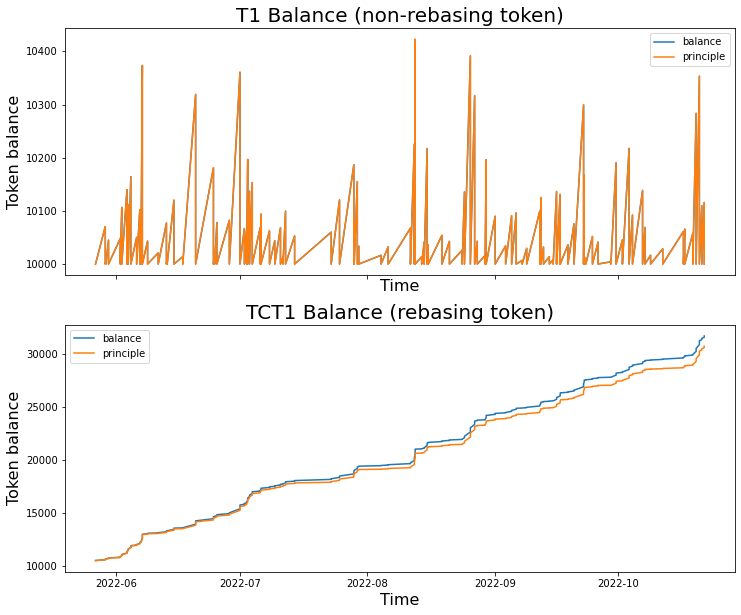

In [13]:
# Analyze Token balances

T1_states = T1.get_state_series(t1_addr)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TCT1_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (non-rebasing token)", fontsize=20)
T1_ax.set_ylabel("Token balance", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TCT1_states = TCT1.get_state_series(tct_addr)
principle = TCT1_states.get_principle() 
balance = TCT1_states.get_balance() 
tSamp = TCT1_states.get_tstamp() 

TCT1_ax.plot(tSamp[1:], balance[1:], label='balance') 
TCT1_ax.plot(tSamp[1:], principle[1:], label='principle') 
TCT1_ax.set_title("TCT1 Balance (rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("Token balance", fontsize=16)
TCT1_ax.set_xlabel('Time', fontsize=16)
TCT1_ax.legend()